# Structured data classification with data from coffea processor

Distinguish `ttgamma` vs. `ttbar`

In [1]:
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot
import re

from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
tf.__version__

'2.3.0'

In [3]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self):
        ## Initializer: define outputs.

        # Declare axes
        dataset_axis = hist.Cat("dataset","Dataset")
        
        photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
        photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
        photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
        photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
        photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
        
        jet_count_axis = hist.Bin("count","Jet number",5,0,5)
        jet_pt_axis = hist.Bin("pt","jet $p_T$ [GeV]", 40, 0, 400)
        jet_eta_axis = hist.Bin("eta","jet $\eta$", 50, -2.5, 2.5)
        jet_phi_axis = hist.Bin("phi","jet $\phi$", 64, -3.2, 3.2)
        jet_mass_axis = hist.Bin("mass","jet mass", 40, 0, 10)
        
        muon_pt_axis = hist.Bin("pt","muon $p_T$ [GeV]", 40, 0, 400)
        muon_eta_axis = hist.Bin("eta","muon $\eta$", 50, -2.5, 2.5)
        muon_phi_axis = hist.Bin("phi","muon $\phi$", 64, -3.2, 3.2)
        muon_mass_axis = hist.Bin("mass","muon mass [GeV]", 40, 0, 10)
        muon_reliso_all_axis = hist.Bin("reliso","muon_pfRelIso03_all",40, -0.5, 6)
        muon_reliso_chg_axis = hist.Bin("reliso","muon_pfRelIso03_chg",40, -0.5, 6)
        
        deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)
        
        
        # Accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators: a list for each variable to be trained on,
            ## filled when an event passes our selection.
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'jet_count': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jet_pt': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jet_eta': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jet_phi': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'jet_mass': processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'muon_pt': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'muon_eta': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'muon_phi': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'muon_mass': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'muon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'muon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(1,1))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(1,1))),
            
            'label': processor.column_accumulator(np.ndarray(shape=(1,1))),
            # delta R between photon & lepton, photon & jet
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            
            'jet_count_hist': hist.Hist("Counts", dataset_axis, jet_count_axis),
            'jet_pt_hist': hist.Hist("Counts", dataset_axis, jet_pt_axis),
            'jet_eta_hist': hist.Hist("Counts", dataset_axis, jet_eta_axis),
            'jet_phi_hist': hist.Hist("Counts", dataset_axis, jet_phi_axis),
            'jet_mass_hist': hist.Hist("Counts", dataset_axis, jet_mass_axis),
            
            'muon_pt_hist': hist.Hist("Counts", dataset_axis, muon_pt_axis),
            'muon_eta_hist': hist.Hist("Counts", dataset_axis, muon_eta_axis),
            'muon_phi_hist': hist.Hist("Counts", dataset_axis, muon_phi_axis),
            'muon_mass_hist': hist.Hist("Counts", dataset_axis, muon_mass_axis),
            'muon_reliso_all_hist': hist.Hist("Counts", dataset_axis, muon_reliso_all_axis),
            'muon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, muon_reliso_chg_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    

    # The process method is where the heart of the analysis is.  
    # This is where all of the selections are done and the histograms get filled 
    #  (things you did in notebook cells before will be done here instead)
    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        ## To access variables from the ntuples, use the "events" object
        ## The dataset name is part of events.metadata
        dataset = events.metadata['dataset']

        ## The coffea NanoEventSchema packages all photon variables (columns) into the events.Muon object
        ## Each variable can be accessed using photons.key_name
        
        ######## Select good photons ########
        photons = events.Photon
        photonSelect= ((photons.pt>20) & 
                        (abs(photons.eta) < 1.4442) &
                        (photons.isScEtaEE | photons.isScEtaEB) &
                        (photons.electronVeto) & 
                        np.invert(photons.pixelSeed) 
                       )
        tightPhotons = photons[photonSelect]
        
        ## other objects (for event selection):
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                           (abs(electrons.eta)<2.1) &
                            electrons.cutBased>=4   
                         )
        tightEle = electrons[electronSelectTight]
        
        
        ######## Select good events #########
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        # Select events passing the trigger, with exactly one tight muon, ≥4 jets, ≥ 1 b-tagged jets, and 0 electrons. 
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)==1))

        # Fill the muon_pt histogram using the tightMuons in events that pass our selection 
        # Note that ak.flatten() is required when filling a histogram to remove the jaggedness
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.flatten(tightPhotons[eventSelection,:1].pt))
        output['photon_eta_hist'].fill(dataset=dataset,
                                      eta=ak.flatten(tightPhotons[eventSelection,:1].eta))
        output['photon_phi_hist'].fill(dataset=dataset,
                                      phi=ak.flatten(tightPhotons[eventSelection,:1].phi))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                         reliso=ak.flatten(tightPhotons[eventSelection,:1].pfRelIso03_all))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                         reliso=ak.flatten(tightPhotons[eventSelection,:1].pfRelIso03_chg))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                      sieie=ak.flatten(tightPhotons[eventSelection,:1].sieie))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.flatten(tightPhotons[eventSelection,:1].r9))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                      hoe=ak.flatten(tightPhotons[eventSelection,:1].hoe))
        
        output['jet_count_hist'].fill(dataset=dataset,
                                      count=(ak.num(tightJets)))
        output['jet_pt_hist'].fill(dataset=dataset,
                                   pt=ak.flatten(tightJets[eventSelection,:1].pt))
        output['jet_eta_hist'].fill(dataset=dataset,
                                    eta=ak.flatten(tightJets[eventSelection,:1].eta))
        output['jet_phi_hist'].fill(dataset=dataset,
                                      phi=ak.flatten(tightJets[eventSelection,:1].phi))
        output['jet_mass_hist'].fill(dataset=dataset,
                                     mass=ak.flatten(tightJets[eventSelection,:1].mass))
        
        output['muon_pt_hist'].fill(dataset=dataset,
                                   pt=ak.flatten(tightMuons[eventSelection,:1].pt))
        output['muon_eta_hist'].fill(dataset=dataset,
                                    eta=ak.flatten(tightMuons[eventSelection,:1].eta))
        output['muon_phi_hist'].fill(dataset=dataset,
                                      phi=ak.flatten(tightMuons[eventSelection,:1].phi))
        output['muon_mass_hist'].fill(dataset=dataset,
                                     mass=ak.flatten(tightMuons[eventSelection,:1].mass))
        output['muon_reliso_all_hist'].fill(dataset=dataset,
                                           reliso=ak.flatten(tightMuons[eventSelection,:1].pfRelIso03_all))
        output['muon_reliso_chg_hist'].fill(dataset=dataset,
                                           reliso=ak.flatten(tightMuons[eventSelection,:1].pfRelIso03_chg))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                           deltar=ak.flatten(tightPhotons[eventSelection,:1].delta_r(tightMuons[eventSelection,:1])))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                           deltar=ak.flatten(tightPhotons[eventSelection,:1].delta_r(tightJets[eventSelection,:1])))
        
        
        # Leading photon
        pt=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True)))
        output['photon_pt']+=pt
        
        eta=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.eta[eventSelection,:1],1,clip=True)))
        output['photon_eta']+=eta
        
        phi=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.phi[eventSelection,:1],1,clip=True)))
        output['photon_phi']+=phi
        
        reliso_all=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.pfRelIso03_all[eventSelection,:1],1,clip=True)))
        output['photon_pfRelIso03_all']+=reliso_all
        
        reliso_chg=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.pfRelIso03_chg[eventSelection,:1],1,clip=True)))
        output['photon_pfRelIso03_chg']+=reliso_chg
        
        sieie=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.sieie[eventSelection,:1],1,clip=True)))
        output['photon_sieie']+=sieie
        
        r9=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.r9[eventSelection,:1],1,clip=True)))
        output['photon_r9']+=r9
        
        hoe=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons.hoe[eventSelection,:1],1,clip=True)))
        output['photon_hoe']+=hoe
        
        ###
        #count=processor.column_accumulator(ak.to_numpy(ak.num(tightJets[eventSelection,:1])))
        #output['jet_count']+=count
        
        pt=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightJets.pt[eventSelection,:1],1,clip=True)))
        output['jet_pt']+=pt
        
        eta=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightJets.eta[eventSelection,:1],1,clip=True)))
        output['jet_eta']+=eta
        
        phi=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightJets.phi[eventSelection,:1],1,clip=True)))
        output['jet_phi']+=phi
        
        mass=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightJets.mass[eventSelection,:1],1,clip=True)))
        output['jet_mass']+=mass
        
        ###
        pt=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.pt[eventSelection,:1],1,clip=True)))
        output['muon_pt']+=pt
        
        eta=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.eta[eventSelection,:1],1,clip=True)))
        output['muon_eta']+=eta
        
        phi=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.phi[eventSelection,:1],1,clip=True)))
        output['muon_phi']+=phi
        
        mass=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.mass[eventSelection,:1],1,clip=True)))
        output['muon_mass']+=mass
        
        reliso_all=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.pfRelIso03_all[eventSelection,:1],1,clip=True)))
        output['muon_pfRelIso03_all']+=reliso_all
        
        reliso_chg=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightMuons.pfRelIso03_chg[eventSelection,:1],1,clip=True)))
        output['muon_pfRelIso03_chg']+=reliso_chg
        
        ###
        deltar=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons[eventSelection,:1].delta_r(tightMuons[eventSelection,:1]),1,clip=True)))
        output['deltaR_photon_lepton']+=deltar
        
        deltar=processor.column_accumulator(ak.to_numpy(ak.pad_none(tightPhotons[eventSelection,:1].delta_r(tightJets[eventSelection,:1]),1,clip=True)))
        output['deltaR_photon_jet']+=deltar
        
        
        if dataset=='TTGamma':
            output['label'] += processor.column_accumulator(np.ones_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        elif dataset=='TTbar':
            output['label'] += processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        else:
            output['label'] += processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.pad_none(tightPhotons.pt[eventSelection,:1],1,clip=True))))
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
           #"WGamma":[f"{skimDir}/WGamma_2016_skim.root"],
           #"Z+jets":[f'{skimDir}/DYjetsM50_ext2_2016_skim_1of10.root'],
           #"W+3jets":[f"{skimDir}/W3jets_2016_skim.root"],
           #"W+4jets":[f"{skimDir}/W4jets_2016_skim.root"],
          }

#filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
#              }

In [5]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
    #maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

In [6]:
'''
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)
'''

'\noutputData = processor.run_uproot_job(\n    filesetData,\n    "Events",\n    PhotonSelector(),\n    processor.futures_executor,\n    executor_args={"schema": SkimmedSchema,\'workers\': 4},\n    chunksize=1000000,\n)\n'

In [7]:
'''
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")
'''

'\nnEvents = {}\nfor d in fileset:\n    if not d in nEvents:\n        nEvents[d] = 0\n    for fName in fileset[d]:\n        with uproot.open(fName)[\'hEvents\'] as hEvents:\n            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]\ncx = {\'TTGamma\':7.509,\n     \'TTbar\': 380.095,\n     \'WGamma\':489,\n     \'Z+jets\':6077.22,\n     \'W+3jets\':1165.8108,\n     \'W+4jets\':592.9176}\nlumi_weight = {}\nfor keyName in fileset:\n    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]\n    \nfor key, obj in outputMC.items():\n    if isinstance(obj, hist.Hist):\n        obj.scale(lumi_weight, axis="dataset")\n'

In [8]:
'''
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}
'''

"\ndata_err_opts = {\n    'linestyle':'none',\n    'marker': '.',\n    'markersize': 10.,\n    'color':'k',\n    'elinewidth': 1,\n}\n"

<AxesSubplot:xlabel='photon $p_{T}$ [GeV]', ylabel='Counts'>

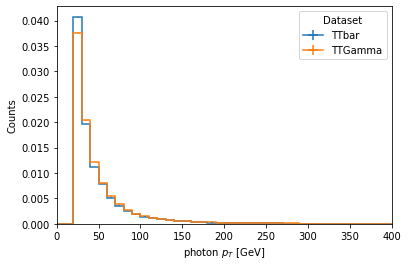

In [9]:
# Histograms ###

hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon $\\eta$', ylabel='Counts'>

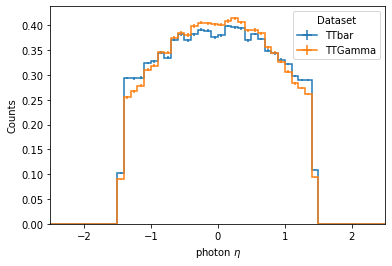

In [10]:
hist.plot1d(outputMC['photon_eta_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon $\\phi$', ylabel='Counts'>

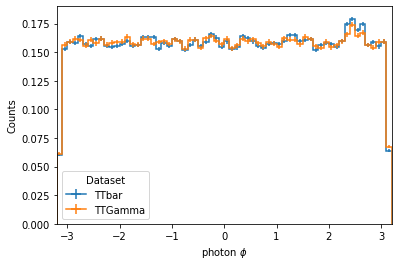

In [11]:
hist.plot1d(outputMC['photon_phi_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon pfRelIso03_all', ylabel='Counts'>

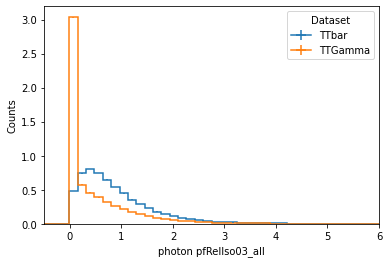

In [12]:
hist.plot1d(outputMC['photon_reliso_all_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon pfRelIso03_chg', ylabel='Counts'>

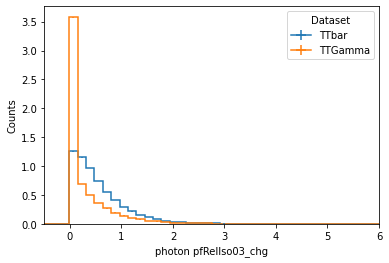

In [13]:
hist.plot1d(outputMC['photon_reliso_chg_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon sigma I eta I eta', ylabel='Counts'>

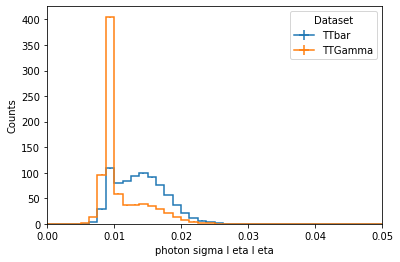

In [14]:
hist.plot1d(outputMC['photon_sieie_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon R9', ylabel='Counts'>

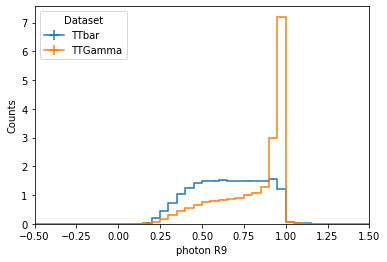

In [15]:
hist.plot1d(outputMC['photon_r9_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='photon H over E', ylabel='Counts'>

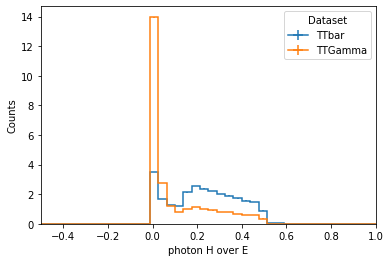

In [16]:
hist.plot1d(outputMC['photon_hoe_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

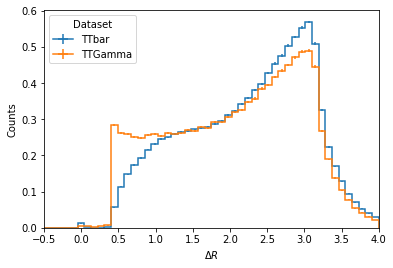

In [17]:
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

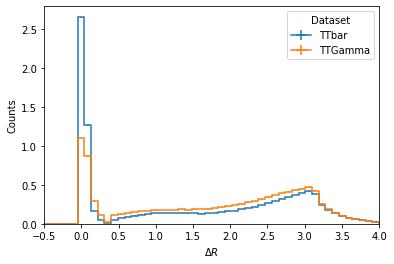

In [18]:
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)

## Preprocessing & training

In [19]:
np.array(outputMC['deltaR_photon_lepton'].value)[:,0].shape

(855579,)

In [20]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value)[:,0],
    'photon_eta': np.array(outputMC['photon_eta'].value)[:,0],
    'photon_phi': np.array(outputMC['photon_phi'].value)[:,0],
    'photon_hoe': np.array(outputMC['photon_hoe'].value)[:,0],
    'photon_r9': np.array(outputMC['photon_r9'].value)[:,0],
    'photon_sieie': np.array(outputMC['photon_sieie'].value)[:,0],
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value)[:,0],
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value)[:,0],
    
    #'jet_count': np.array(outputMC['jet_count'].value)[:,0],
    'jet_pt': np.array(outputMC['jet_pt'].value)[:,0],
    'jet_eta': np.array(outputMC['jet_eta'].value)[:,0],
    'jet_phi': np.array(outputMC['jet_phi'].value)[:,0],
    'jet_mass': np.array(outputMC['jet_mass'].value)[:,0],
    
    'muon_pt': np.array(outputMC['muon_pt'].value)[:,0],
    'muon_eta': np.array(outputMC['muon_eta'].value)[:,0],
    'muon_phi': np.array(outputMC['muon_phi'].value)[:,0],
    'muon_mass': np.array(outputMC['muon_mass'].value)[:,0],
    'muon_pfRelIso03_all': np.array(outputMC['muon_pfRelIso03_all'].value)[:,0],
    'muon_pfRelIso03_chg': np.array(outputMC['muon_pfRelIso03_chg'].value)[:,0],
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value)[:,0],
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value)[:,0],
    
    'target': np.array(outputMC['label'].value)[:,0]
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,jet_pt,jet_eta,...,jet_mass,muon_pt,muon_eta,muon_phi,muon_mass,muon_pfRelIso03_all,muon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,target
count,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,...,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000,855579.000000
mean,48.350057,0.003989,0.012482,0.174138,0.724939,0.012634,0.733765,0.455420,140.578637,0.004473,...,16.464279,70.038697,0.006301,-0.005696,0.105713,0.016173,0.008393,2.186535,1.629632,0.431477
std,40.563230,0.781453,1.815523,0.161405,0.239834,0.003758,0.820339,0.556702,75.768024,1.020286,...,10.263589,40.682925,1.052721,1.816676,0.000000,0.024052,0.015345,0.864183,1.264622,0.495283
min,20.000013,-1.444092,-3.141602,0.000000,0.100952,0.000196,0.000000,0.000000,34.531250,-2.399902,...,1.002930,30.000050,-2.399902,-3.141602,0.105713,0.000000,0.000000,0.000061,0.000000,0.000000
25%,25.436474,-0.636597,-1.558594,0.007080,0.548340,0.009323,0.139816,0.047417,92.937500,-0.756714,...,10.601562,42.410805,-0.767700,-1.581543,0.105713,0.000000,0.000000,1.495825,0.082460,0.000000
50%,34.645893,0.008839,0.013788,0.160645,0.752930,0.011787,0.520099,0.288517,121.062500,0.005845,...,14.171875,58.101337,0.005819,-0.011141,0.105713,0.006353,0.000000,2.317909,1.807442,0.000000
75%,54.804638,0.645386,1.587158,0.300781,0.932617,0.015381,1.047740,0.658474,163.875000,0.768127,...,19.281250,84.085567,0.780396,1.572021,0.105713,0.022676,0.011128,2.893058,2.794548,1.000000
max,1075.912109,1.444092,3.141602,2.867188,20.515625,0.030167,24.023279,17.346630,1776.000000,2.399902,...,267.250000,885.079102,2.399902,3.141602,0.105713,0.450496,0.149926,4.904033,4.918265,1.000000


In [21]:
df['target'].value_counts()

0.0    486416
1.0    369163
Name: target, dtype: int64

In [22]:
# split into features and labels
X = np.array(df.drop(['target'],axis=1))
y = df['target']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [23]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.fit_transform(X_val)
X_test_scaled=scaler.fit_transform(X_test)

In [24]:
model = Sequential()
model.add(Dense(32, input_shape=(20,), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=128)

Epoch 1/5
4011/4011 [==============================] - 6s 2ms/step - loss: 0.4976 - accuracy: 0.7795
Epoch 2/5
4011/4011 [==============================] - 7s 2ms/step - loss: 0.4842 - accuracy: 0.7884
Epoch 3/5
4011/4011 [==============================] - 6s 2ms/step - loss: 0.4818 - accuracy: 0.7898
Epoch 4/5
4011/4011 [==============================] - 7s 2ms/step - loss: 0.4805 - accuracy: 0.7904
Epoch 5/5
4011/4011 [==============================] - 7s 2ms/step - loss: 0.4796 - accuracy: 0.7910


In [165]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.4809
Test accuracy: 0.79056


In [27]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

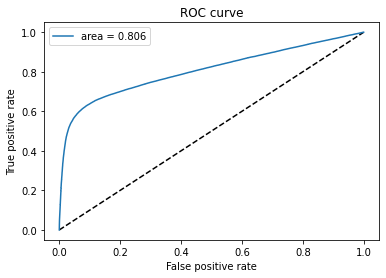

In [28]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [29]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

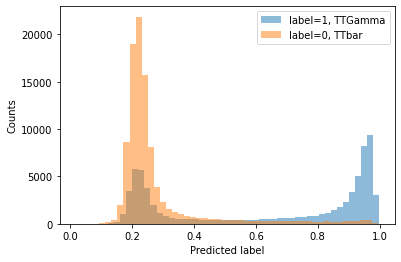

In [30]:
plt.hist(predTrue,bins=50,alpha=0.5,label='label=1, TTGamma')
plt.hist(predFalse,bins=50,alpha=0.5,label='label=0, TTbar')

plt.xlabel('Predicted label')
plt.ylabel('Counts')
plt.title('')
plt.legend(loc='best')
plt.show()

In [31]:
xTrue = X_test[y_test==True]
xFalse = X_test[y_test==False]

tp = predTrue>0.5  # label is 1, prediction is 1
tp = tp[:,0]
fp = predFalse>0.5 # label is 0, prediction is 1
fp = fp[:,0]
tn = predFalse<0.5 # label is 0, prediction is 0
tn = tn[:,0]
fn = predTrue<0.5  # label is 1, prediction is 0
fn = fn[:,0]

xTP = xTrue[tp]
xFP = xFalse[fp]
xTN = xFalse[tn]
xFN = xTrue[fn]

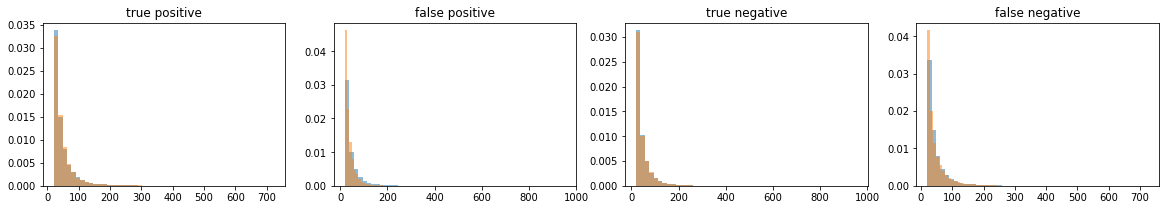

In [117]:
fig, axs = plt.subplots(1,4,figsize=(20,3))

axs[0].set_title('true positive')
axs[0].hist(xTrue[:,0],bins=50,density=True,alpha=0.5)
axs[0].hist(xTP[:,0],bins=50,density=True,alpha=0.5)

axs[1].set_title('false positive')
axs[1].hist(xFalse[:,0],bins=50,density=True,alpha=0.5)
axs[1].hist(xFP[:,0],bins=50,density=True,alpha=0.5)

axs[2].set_title('true negative')
axs[2].hist(xFalse[:,0],bins=50,density=True,alpha=0.5)
axs[2].hist(xTN[:,0],bins=50,density=True,alpha=0.5)

axs[3].set_title('false negative')
axs[3].hist(xTrue[:,0],bins=50,density=True,alpha=0.5)
axs[3].hist(xFN[:,0],bins=50,density=True,alpha=0.5)

plt.show()

## Decision tree classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [35]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,jet_pt,jet_eta,...,jet_mass,muon_pt,muon_eta,muon_phi,muon_mass,muon_pfRelIso03_all,muon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,target
0,53.171295,-0.650879,-2.975586,0.301758,0.856934,0.013046,0.779366,0.697734,174.8750,-0.654907,...,37.968750,128.442123,-0.027340,-0.064255,0.105713,0.005867,0.005867,2.977356,0.087495,0.0
1,57.229649,0.519287,-1.353516,0.183105,0.735352,0.011314,0.327964,0.225708,415.7500,-1.585205,...,32.875000,171.882904,0.527344,-2.083984,0.105713,0.000000,0.000000,0.730513,3.393098,0.0
2,129.583298,1.288086,0.755493,0.374023,0.750977,0.015610,1.093135,0.819927,225.1250,1.299316,...,29.078125,140.628632,0.141174,-2.837402,0.105713,0.000000,0.000000,2.924562,0.015457,0.0
3,39.797897,-0.128571,2.544434,0.257812,0.679688,0.012558,0.222316,0.081593,103.9375,-0.526733,...,10.648438,108.521317,0.591064,-0.277588,0.105713,0.000000,0.000000,2.912333,1.008204,0.0
4,122.852882,-1.407959,0.123810,0.208008,0.615234,0.013283,0.489129,0.481821,163.2500,-1.413330,...,14.718750,118.424644,0.059258,-1.565186,0.105713,0.020826,0.000000,2.237282,0.012614,0.0


In [36]:
# feature selection & splitting data
X = df.drop(['target'],axis=1)
y = df.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)

In [91]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [38]:
### build & train decision tree model ###
clf = DecisionTreeClassifier(criterion="entropy",max_depth=3).fit(X_train_scaled,y_train)
y_pred = clf.predict(X_test_scaled)

In [135]:
print("Test accuracy: ",clf.score(X_test_scaled, y_test))
print("Train accuracy:",clf.score(X_train_scaled, y_train))

Test accuracy:  0.7791673484653685
Train accuracy: 0.7798553545942254


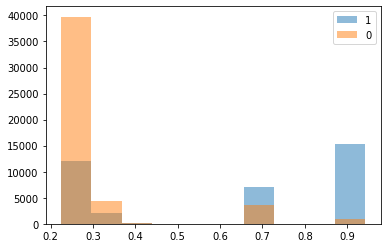

In [158]:
prob = clf.predict_proba(X_test_scaled)

plt.hist(prob[y_test==True][:,1],alpha=0.5,label="1")
plt.hist(prob[y_test==False][:,1],alpha=0.5,label="0")
plt.legend()
plt.show()

In [45]:
clf.tree_.threshold

array([-0.78451511, -0.50858772, -0.33348672, -2.        , -2.        ,
        0.77024433, -2.        , -2.        , -0.68115938, -0.1784437 ,
       -2.        , -2.        ,  0.77227834, -2.        , -2.        ])

In [46]:
clf.tree_.impurity

array([0.98652196, 0.520525  , 0.35935053, 0.31700061, 0.96678324,
       0.9331828 , 0.8586303 , 0.86738911, 0.89125816, 0.99590934,
       0.92217699, 0.91940502, 0.78077345, 0.76789153, 0.87198653])

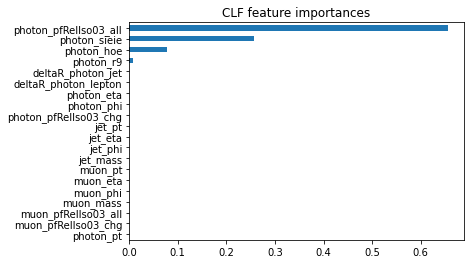

In [48]:
important = pd.Series(data=clf.feature_importances_, index=X_train_scaled.columns).sort_values()

fig = plt.subplots()
important.plot(kind='barh')
plt.title('CLF feature importances')
plt.show()

In [49]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.07708014, 0.00873547,
       0.25784649, 0.6563379 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

## AdaBoostClassifier

In [83]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion="entropy",max_depth=3))
abc.fit(X_train_scaled,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3))

In [168]:
y_pred = abc.predict(X_test_scaled)

print("Test accuracy: ", abc.score(X_test_scaled,y_test))
print("Train accuracy:", abc.score(X_train_scaled,y_train))

Test accuracy:  0.7918838682531149
Train accuracy: 0.7939627620545414


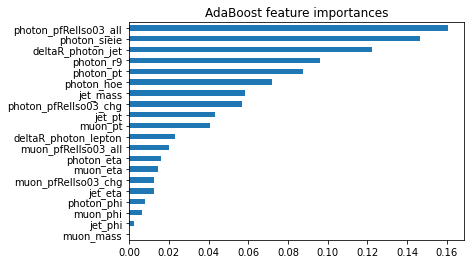

In [169]:
important = pd.Series(data=abc.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots()
important.plot(kind='barh')
plt.title('AdaBoost feature importances')
plt.show()

In [170]:
prob = abc.predict_proba(X_test_scaled)
prob  # [probability of being 0,  probability of being 1],

array([[0.50682417, 0.49317583],
       [0.51223773, 0.48776227],
       [0.48418944, 0.51581056],
       ...,
       [0.48432399, 0.51567601],
       [0.49025622, 0.50974378],
       [0.50899753, 0.49100247]])

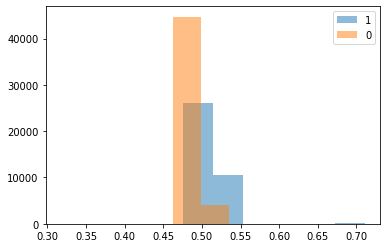

In [171]:
plt.hist(prob[y_test==True][:,1],alpha=0.5,label="1")
plt.hist(prob[y_test==False][:,1],alpha=0.5,label="0")
plt.legend()
plt.show()

In [173]:
for i, score in enumerate(abc.staged_score(X_test_scaled,y_test)):
    print(i+1,"train score", score)
    if i == 9:
        break

1 train score 0.7791673484653685
2 train score 0.779237476331845
3 train score 0.7810257369269968
4 train score 0.7809672970382664
5 train score 0.7834568362981836
6 train score 0.7866944061338508
7 train score 0.7878281399752215
8 train score 0.7877112601977606
9 train score 0.788283971107319
10 train score 0.7883657869515417


## GradientBoostingClassifier

In [174]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled,y_train)

KeyboardInterrupt: 

In [ ]:
print("Test accuracy: ",gbc.score(X_test_scaled,y_test))
print("Train accuracy:",gbc.score(X_train_scaled,y_train))

In [ ]:
important = pd.Series(data=gbc.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots()
important.plot(kind='barh')
plt.title('GradientBoosting feature importances')
plt.show()

In [ ]:
prob = gbc.predict_proba(X_test_scaled)

plt.hist(prob[y_test==True][:,1],bins=50,alpha=0.5,label="target=1")
plt.hist(prob[y_test==False][:,1],bins=50,alpha=0.5,label="target=0")
plt.xlabel("predicted label")
plt.ylabel("counts")
plt.legend()
plt.show()